In [1]:
# Import packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import IPython
from IPython.display import HTML


In [2]:
colors = {"coop": "blue", "cheat": "red"}

In [3]:
# initialise model

# bacteria class (agent) - CA
class Bacteria:
    def __init__(self, energy, recombination, breed, loc):
        # int for bacteria energy
        self.energy = energy
        # boolean for if it takes part in recombination
        self.recombination = recombination
        # int for breed
        self.breed = breed
        # list of ints for location [x, y]
        self.loc = loc
        # string for the color according to the breed
        self.color = colors[breed]
    
    # method to set color based on breed
    def set_breed(self, breed):
        self.breed = breed
        self.color = colors[breed]

    # method to get possible move options
    def get_move_options(self, size):
        options = []  # to store possible move options
        # check if x-coordinate is not at left edge of grid
        if self.loc[0] != 0:
            options.append([self.loc[0] - 1, self.loc[1]])
        # check if x-coordinate is not at right edge of grid
        if self.loc[0] != size[0] - 1:
            options.append([self.loc[0] + 1, self.loc[1]])
        # check if y-coordinate is not at top edge of grid
        if self.loc[1] != 0:
            options.append([self.loc[0], self.loc[1] - 1])
        # check if y-coordinate is not at bottom edge of grid
        if self.loc[1] != size[1] - 1:
            options.append([self.loc[0], self.loc[1] + 1])
        return options

In [4]:
# simulation class - we can remove print statements, only for testing - CA
# TODO: add tracking and return of simulation data over generations
# TODO: add animation of simulation based on tracking of data over generations

# simulation class
class Sim:
    def __init__(self, 
                 start_energy, 
                 population_size, 
                 population_viscosity, 
                 recombination_cost,
                 mutation_rate, 
                 recombination_rate, 
                 percent_recombination, 
                 percent_cooperation,
                 contribution, 
                 multiplier, 
                 max_x, 
                 max_y):
        
        # attribute initialization
        self.start_energy = start_energy  # energy is consumed over time. when energy is 0, bacteria dies
        self.population_size = population_size  # when cells die, remaining cells reproduce to keep population size constant
        self.population_viscosity = population_viscosity  # no of gens each cell remains in same loc before moving to adjacent loc
        self.recombination_cost = recombination_cost  # subtracts from resources available to each cell that recombines
        self.mutation_rate = mutation_rate  # rate at which coops produce cheat offspring
        self.recombination_rate = recombination_rate  # rate at which recombs change phenotype of other cells in same loc (coops make others coop, cheats make others cheat, converted cells are also recomb)
        self.percent_recombination = percent_recombination  # initial percent of recombiners
        self.percent_cooperation = percent_cooperation  # initial percent of cooperators
        self.contribution = contribution  # all coops contribute some fitness to common pool
        self.multiplier = multiplier  # common pool value is multiplied (benefit of cooperation)
        self.max_x = max_x  # x-coordinate of grid
        self.max_y = max_y  # y-coordinate of grid
        
        # list to store bacteria
        self.bacteria = []

        # number of recombination and cooperation bacteria
        self.num_rec = int(np.round(population_size * percent_recombination))  # total population size * percent recombiners, round to nearest int
        self.num_coop = int(np.round(population_size * percent_cooperation))  # total population size * percent cooperators, round to nearest int

        np.random.seed(0)

        # randomly assign recombination and cooperation to bacteria
        index_rec = np.random.choice(population_size, self.num_rec, replace=False)
        index_coop = np.random.choice(population_size, self.num_coop, replace=False)

        # create bacteria
        for i in np.arange(population_size):
            bac = Bacteria(start_energy, True if i in index_rec else False, "coop" if i in index_coop else "cheat",
                           [np.random.choice(max_x, 1)[0], np.random.choice(max_y,1)[0]])
            self.bacteria.append(bac)
    
    # method to simulate a generation
    def simulate_gen(self, gen):
        #print("starting gen", gen)
        # coops contribute public goods at the cost of energy
        def contribute(bac):
            if bac.breed == "coop":
                bac.energy -= self.contribution  # coops lose energy
            return bac
        # apply contribute function to all bacteria
        self.bacteria = list(map(contribute, self.bacteria))

        # all cells benefit from public good
        def benefit(bac, amt):
            bac.energy += amt
            return bac
        # AP change for visualisation 
        coop_benefit = (self.num_coop * self.multiplier) / len(self.bacteria) if len(self.bacteria) > 0 else 0
        self.bacteria = list(map(benefit, self.bacteria, [coop_benefit] * len(self.bacteria)))
        # apply benefit function to all bacteria
        # self.bacteria = list(map(benefit, self.bacteria, [(self.num_coop * self.multiplier) / len(self.bacteria)]
        #                          * len(self.bacteria)))
        # if len(self.bacteria) > 0:
        #     coop_benefit = (self.num_coop * self.multiplier) / len(self.bacteria)
        # else:
        #     coop_benefit = 0  # No benefit if there are no bacteria

        # self.bacteria = list(map(benefit, self.bacteria, [coop_benefit] * len(self.bacteria)))

        
        # cells lose energy
        def update_fitness(bac):
            # random energy decrease
            if np.random.choice(2, 1) == 1:
                bac.energy -= 1
            # recombiners lose additional energy
            if bac.recombination:
                bac.energy -= self.recombination_cost
            return bac
        # apply update_fitness function to all bacteria
        self.bacteria = list(map(update_fitness, self.bacteria))

        # bacteria die if energy is < 0
        alive_bac = []  # to store bacteria that are alive
        for b in self.bacteria:
            # bacteria with energy < 0 die
            if b.energy < 0:
                if b.breed == "coop":
                    self.num_coop -= 1  # decrease number of coops
                if b.recombination:
                    self.num_rec -= 1  # decrease number of recombiners
            else:
                alive_bac.append(b)  # if energy > 0, add bacteria to alive_bac list (includes cheaters)
        
        # update bacteria list
        self.bacteria = alive_bac

        # if no bacteria are left, method returns early
        # if len(self.bacteria) == 0:
        #     return
        #AP change for visualisation
        if len(self.bacteria) == 0:
            print(f"All bacteria dead at generation {gen}")
         

        # reproduction
        # reproduce until population size is reached
        while len(self.bacteria) < self.population_size:
            # randomly select parent
            parent = self.bacteria[np.random.choice(len(self.bacteria), 1)[0]]
            # randomly select whether to mutate or not
            ## draw 1 sample from [0,1] array with probabilities (1-mutation_rate) and (mutation_rate)
            ## 0 means no mutation, 1 means mutation
            mutate = np.random.choice(2, 1, p=[1 - self.mutation_rate, self.mutation_rate])[0]
            # if mutation does not occur:
            if mutate == 0:  # child has same breed as parent
                breed = parent.breed 
            # if mutation occurs:
            elif parent.breed == "coop":  # if parent is coop, child is cheat
                breed = "cheat"
            else:
                breed = "coop"  # if parent is cheat, child is coop
            if breed == "coop":  # if child is coop, increase number of coops
                self.num_coop += 1
            if parent.recombination:  # if parent is recombiner, child is recombiner
                self.num_rec += 1
            # create child
            # bac = Bacteria(parent.energy, parent.recombination, breed, parent.loc)
            bac = Bacteria(
                parent.energy, 
                parent.recombination, 
                breed, 
                [np.random.randint(0, self.max_x), np.random.randint(0, self.max_y)]  # Random position
            )
            # add child to bacteria list
            self.bacteria.append(bac)

        # conversion/recombination
        if self.num_rec != 0:
            # cells in each location
            bac_locs = {}
            # number of recombiners in each location
            bac_rec = {}

            # group bacteria by location
            for b in self.bacteria:
                # if location is already in bac_locs, append bacteria to list
                if str(b.loc) in bac_locs.keys():
                    bac_locs[str(b.loc)].append(b)
                    # if bacteria is recombiner, increase count of recombiners in location
                    if b.recombination:
                        bac_rec[str(b.loc)] += 1
                # if location is not in bac_locs, create new list with bacteria
                else:
                    # if bacteria is recombiner, set count of recombiners in location to 1
                    bac_locs[str(b.loc)] = [b]
                    if b.recombination:
                        bac_rec[str(b.loc)] = 1
                    # if bacteria is not recombiner, set count of recombiners in location to 0
                    else:
                        bac_rec[str(b.loc)] = 0

            # recombination
            for k in bac_locs.keys():
                # if no recombiners in location or all bacteria are recombiners, skip location
                if bac_rec[k] == 0 or bac_rec[k] == len(bac_locs[k]):
                    continue
                # for each bacteria in location
                for b in bac_locs[k]:
                    # if bacteria is not yet a recombiner:
                    if not b.recombination:
                        # pick whether to recombine or not for each recombiner based on recombination rate
                        recombine = np.random.choice(2, bac_rec[k], p=[1-self.recombination_rate, self.recombination_rate])
                        # if any bacteria recombine, increment number of recombiners
                        if np.sum(recombine) > 0:
                            b.recombination = True
                            self.num_rec += 1

        # movement
        ## bacteria move to adjacent location every population_viscosity generations
        if (gen + 1) % self.population_viscosity == 0:
            for b in self.bacteria:
                # use get_move_options method defined previously to get possible move options
                move_ops = b.get_move_options([self.max_x, self.max_y])
                # randomly select new location from possible move options
                b.loc = move_ops[np.random.choice(len(move_ops), 1)[0]]

    # method to simulate generations    
    def simulate(self, gens):
        #print("starting simulation")
        for g in np.arange(gens):
            self.simulate_gen(g)
            if len(self.bacteria) == 0:
                #print("all dead")
                break
            #print("***results after gen***", g)
            #for b in self.bacteria:
                #print(b.recombination)
                #print(b.breed)
                #print(b.energy)
                #print(b.loc)
    
    #AP change for visualisation
    def get_grid_state(self):
        grid = np.zeros((self.max_x, self.max_y, 3))  # Example: 3 channels for attributes
        for b in self.bacteria:
            x, y = b.loc
            # Example: Encode cooperation as 1, recombination as 2
            grid[x, y, 0] += 1 if b.breed == "coop" else 0
            grid[x, y, 1] += 1 if b.recombination else 0
            grid[x, y, 2] += b.energy
        return grid
    
    def get_bacteria_data(self):
        positions = []  # Store x, y positions
        colors = []     # Store colors based on attributes
        for b in self.bacteria:
            positions.append(b.loc)
            # Assign colors based on type (e.g., cooperation/recombination)
            if b.breed == "coop":
                color = 'green'
            else:
                color = 'red'
            colors.append(color)
        return positions, colors

In [5]:
# function to define visualisation
from matplotlib.animation import FuncAnimation

def plot_grid(grid, ax, title="Bacterial Simulation"):
    ax.clear()
    ax.set_title(title)
    ax.imshow(grid[:, :, 0], cmap='Greens', interpolation='nearest', alpha=0.7)
    ax.imshow(grid[:, :, 1], cmap='Reds', interpolation='nearest', alpha=0.3)
    ax.set_xticks([])
    ax.set_yticks([])

# def plot_bacteria(positions, colors, ax, title="Bacterial Simulation"):
#     ax.clear()
#     ax.set_title(title)
#     if positions:
#         x, y = zip(*positions)  # Separate x and y coordinates
#         ax.scatter(x, y, c=colors, alpha=0.7)
#     ax.set_xlim(0, 10)  # Adjust based on grid dimensions
#     ax.set_ylim(0, 10)
#     ax.set_xticks([])
#     ax.set_yticks([])

In [6]:
def run_simulation(sim_model, generations, interval=200):
    fig, ax = plt.subplots(figsize=(6, 6))
    
    def update(frame):
        sim_model.simulate_gen(frame)
        grid = sim_model.get_grid_state()
        plot_grid(grid, ax, title=f"Generation: {frame}")
    
    anim = FuncAnimation(fig, update, frames=generations, interval=interval)
    return anim

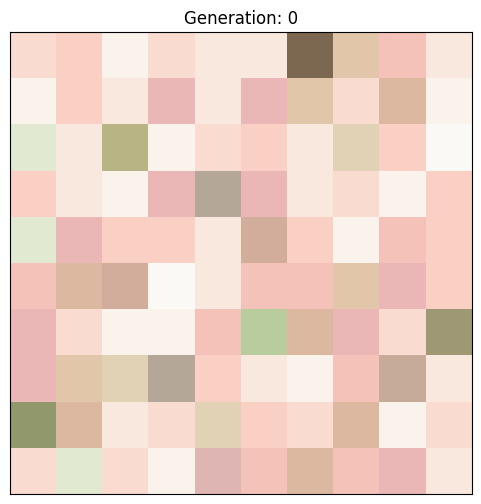

In [10]:
sim = Sim(
    start_energy=10, 
    population_size=400, 
    population_viscosity=3, 
    recombination_cost=1,
    mutation_rate=0.1, 
    recombination_rate=0.2, 
    percent_recombination=0.5, 
    percent_cooperation=0.5,
    contribution=1, 
    multiplier=2, 
    max_x=10, 
    max_y=10
)
anim = run_simulation(sim, generations=50)
HTML(anim.to_jshtml(fps=10))

#### Retired code from a previous simulation that somehow looked worse?

In [65]:
def run_simulation(sim_model, generations, interval=200):
    fig, ax = plt.subplots(figsize=(5, 5))
    
    def update(frame):
        sim_model.simulate_gen(frame)
        if len(sim_model.bacteria) == 0:
            return
        positions, colors = sim_model.get_bacteria_data()
        plot_bacteria(positions, colors, ax, title=f"Generation: {frame}")
    
    anim = FuncAnimation(fig, update, frames=generations, interval=interval)
    return anim

In [ ]:
sim = Sim(
    start_energy=10, 
    population_size=100, 
    population_viscosity=3, 
    recombination_cost=0.1,
    mutation_rate=0.1, 
    recombination_rate=0.2, 
    percent_recombination=0.5, 
    percent_cooperation=0.5,
    contribution=1, 
    multiplier=1, 
    max_x=10, 
    max_y=10
)
anim = run_simulation(sim, generations=50)
HTML(anim.to_jshtml(fps=10))